# Case Study: Zebrafish pigementation

In our previous zebrafish tutorial, we have shown how **{mod}`dynamo`** goes beyond discrete RNA velocity vectors to continuous RNA vector field functions. In this tutorial, we will demonstrate a set of awesome downstream differential geometry and dynamical systems based analyses, enabled by the differentiable vector field functions, to gain deep functional and predictive insights of cell fate transition during zebrafish pigmentation (Saunders, et al. 2019). 

With differential geometry analysis of the continuous vector field functions, we can calculate the **RNA Jacobian** (see our [primer on differential geometry](https://dynamo-release.readthedocs.io/en/latest/Primer.html)), which is a **cell by gene by gene** tensor, encoding the gene regulatory network in each cell. With the Jacobian matrix, we can further derive the **RNA acceleration, curvature**, which are **cell by gene** matrices, just like gene expression dataset. 

In general (see figure below), we can perform differential analyses and gene-set enrichment analyses based on top-ranked acceleration or curvature genes, as well as the top-ranked genes with the strongest self-interactions, top-ranked regulators/targets, or top-ranked interactions for each gene in individual cell types or across all cell types, with either raw or absolute values with the Jacobian tensor. Integrating that ranking information, we can build regulatory networks across different cell types, which can then be visualized with {func}`dynamo.pl.arcPlot`, {func}`dynamo.pl.circosPlot`, or other tools.

<img src="https://raw.githubusercontent.com/Xiaojieqiu/jungle/master/differential_geometry.png">

In this tutorial, we will cover following topics:

- learn continuous RNA velocity vector field functions in different spaces (e.g. umap or pca space)
- calculate RNA acceleration, curvature matrices (**cell by gene**)
- rank genes based on RNA velocity, curvature and acceleration matrices 
- calculate RNA Jacobian tensor (**cell by gene by gene**) for genes with high PCA loadings.
- rank genes based on the jacobian tensor, which including:
 - rank genes with strong positive or negative self-interaction (`divergence` ranking)
 - other rankings, ranking modes including `full_reg`, `full_eff`, `eff`, `reg` and `int`
- build and visualize gene regulatory network with top ranked genes 
- gene enrichment analyses of top ranked genes
- visualize Jacobian derived regulatory interactions across cells 
- visualize gene expression, velocity, acceleration and curvature kinetics along pseudotime trajectory
- learn and visualize models of cell-fate transitions

Import relevant packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

import dynamo as dyn

dyn.configuration.set_figure_params('dynamo', background='white')
dyn.pl.style(font_path='Arial')
dyn.get_all_dependencies_version()

%load_ext autoreload
%autoreload 2

Using already downloaded Arial font from: /tmp/dynamo_arial.ttf
Registered custom font as: Arial


 ███                               ████████        
█████   █████    █████    █████    ███   █████      
   ██████   ██████   ██████   ████████      ████ 
  ___                           ████            ███
 |   \ _  _ _ _  __ _ _ __  ___                 ███
 | |) | || | ' \/ _` | '  \/ _ \█████           ███ 
 |___/ \_, |_||_\__,_|_|_|_\___/█████       ████  
       |__/                        ███   █████     
Tutorial: https://dynamo-release.readthedocs.io/       
                                     █████      



package,umap-learn,typing-extensions,tqdm,statsmodels,setuptools,session-info,seaborn,scipy,requests,pynndescent,pre-commit,pandas,openpyxl,numdifftools,numba,networkx,mudata,matplotlib,loompy,leidenalg,igraph,dynamo-release,colorcet,anndata
version,0.5.7,4.13.2,4.67.1,0.14.4,79.0.0,1.0.1,0.13.2,1.11.4,2.32.3,0.5.13,4.2.0,2.2.3,3.1.5,0.9.41,0.60.0,3.4.2,0.3.1,3.10.3,3.0.8,0.10.2,0.11.8,1.4.2rc1,3.1.0,0.11.4


Set the logging level. Various logging level can be setted according to your needs:

- DEBUG: useful for dynamo development, show all logging information, including those debugging information
- INFO: useful for most dynamo users, show detailed dynamo running information
- WARNING: show only warning information
- ERROR: show only exception or error information
- CRITICAL: show only critical information

In [2]:
%matplotlib inline
from dynamo.dynamo_logger import main_info, LoggerManager
LoggerManager.main_logger.setLevel(LoggerManager.INFO)

### Load processed data or data preprocessing 

If you followed the **zebrafish pigmentation** tutorial, you can load the processed zebrafish adata object here for all downstream analysis. 

In [3]:
adata = dyn.sample_data.zebrafish()
adata

|-----> Downloading data to ./data/zebrafish.h5ad
|-----> File ./data/zebrafish.h5ad already exists.


AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch'
    layers: 'spliced', 'unspliced'

|-----> Downloading data to ./data/zebrafish.h5ad
|-----> File ./data/zebrafish.h5ad already exists.
|-----> Running monocle preprocessing pipeline...
|-----------> filtered out 14 outlier cells
|-----------> filtered out 12746 outlier genes
|-----> PCA dimension reduction
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> computing cell phase...
|-----> [Cell Phase Estimation] completed [49.3193s]
|-----> [Cell Cycle Scores Estimation] completed [0.5694s]
|-----> [Preprocessor-monocle] completed [4.0006s]
|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----------> removing existing M layers:[]...
|-----------> making adata smooth...
|-----> calculating first/second moments...
|-----> [moments calculation] completed [37.9759s]
|-----> retrieve data for non-linear dimension reduction...
|-----> [UMAP] using X_pca with n_pca_components = 30
|-----> <insert> X_umap to obsm in AnnData Object.
|-----> [UMA

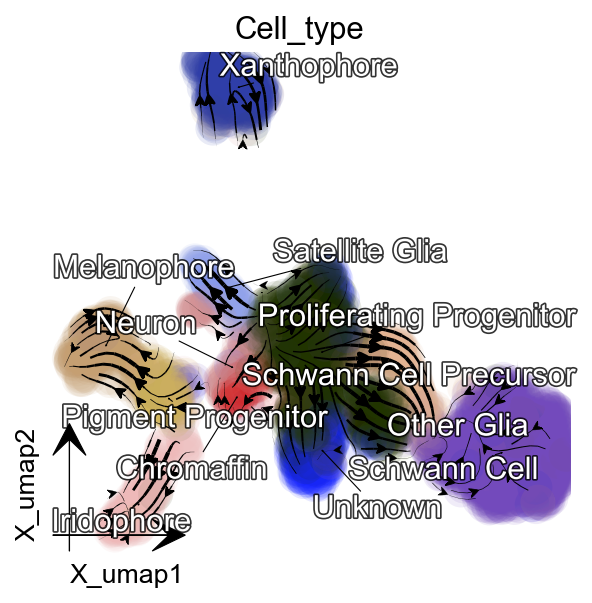

In [4]:
preprocessor = dyn.pp.Preprocessor(cell_cycle_score_enable=True)
preprocessor.preprocess_adata(adata, recipe='monocle')
dyn.tl.dynamics(adata, cores=10)
dyn.tl.reduceDimension(adata)
dyn.tl.cell_velocities(adata)
dyn.tl.cell_velocities(adata)
dyn.pl.streamline_plot(
    adata, color=['Cell_type'], 
    basis='umap', show_legend='on data', 
    s_kwargs_dict={'adjust_legend':True},
    show_arrowed_spines=False,
    figsize=(4,4),
)

If you confronted errors when saving dynamo processed adata object, please see the very end of this tutorial.  

If you would like to start from scratch, use the following code to preprocess the zebrafish adata object (or use your own dataset): 

```python
adata = dyn.sample_data.zebrafish()

dyn.pp.recipe_monocle(adata)
dyn.tl.dynamics(adata, cores=3)

dyn.tl.reduceDimension(adata)
dyn.tl.cell_velocities(adata)

dyn.tl.cell_velocities(adata)
dyn.pl.streamline_plot(adata, color=['Cell_type'])
```

### Differential geometry analysis

In this part we will demonstrate how to leverage **dynamo** to estimate RNA jacobian (reveals state-dependent regulation), RNA acceleration/curvature (reveals earlier drivers and fate decision points), etc.

To gain functional and biological insights, we can perform a series of downstream analysis with the computed differential geometric quantities. We can first rank genes across all cells or in each cell group for any of those differential geometric quantities, followed by gene set enrichment analyses of the top ranked genes, as well as regulatory network construction and visualization.

The differential geometry and dynamical systems (i.e. fixed points, nullclines, etc mentioned in the previous zebrafish tutorial) are conventionally used to describe small-scale systems, while the vector field we build comes from high-dimensional genomics datasets. From this, you can appreciate that with **dynamo**, we are bridging small-scale systems-biology/physics type of thinking with high-dimensional genomics using ML, something really unimaginable until very recently! 

In order to calculate RNA jacobian, acceleration and curvature, we can either learn the vector field function directly in the gene expression space or on the PCA space but then project the differential geometric quantities learned in PCA space back to the original gene expression space. Since we often have thousands of genes, we generally learn vector field in PCA space to avoid the curse of dimensionality and to improve the efficiency and accuracy of our calculation. 

#### Vector field learning in PCA space

To learn PCA basis based RNA velocity vector field function, we need to first project the RNA velocities into PCA space.

In [5]:
dyn.tl.cell_velocities(adata, basis='pca');

Using existing pearson_transition_matrix found in .obsp.
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [1.3163s]
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected


Then we will use the {meth}`dynamo.vf.VectorField` function to learn the vector field function in PCA space. This function relies on [sparseVFC](https://www.sciencedirect.com/science/article/pii/S0031320313002410) to learn the high dimensional vector field function in the entire expression space from sparse single cell velocity vector samples robustly. 

Note that if you don't provide any basis, vector field will be learned in the original gene expression and you can learn vector field for other basis too, as long as you have the RNA velocities projected in that basis. 

Related information for the learned vector field are stored in adata.

In [6]:
dyn.vf.VectorField(
    adata, 
    basis='pca',
    M=100
)

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: PCA. 
        Vector field will be learned in the PCA space.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> [SparseVFC] completed [1.2615s]
|-----> [VectorField] completed [1.4585s]


#### Velocity, acceleration and curvature ranking

To gain functional insights of the biological process under study, we design a set of ranking methods to rank gene's absolute, positive, negative vector field quantities in different cell groups that you can specify. Here we will first demonstrate how to rank genes based on their velocity matrix. 

Basically, the rank functions in the vector field submodule (**{mod}`dynamo.vf`**) of **{mod}`dynamo`** is organized as **rank_**{quantities}**_genes** where {quantities} can be any differential geometry quantities, including, **velocity, divergence, acceleration, curvature, jacobian**:

- {meth}`dynamo.vf.rank_velocity_genes`(adata, groups='Cell_type')
- {meth}`dynamo.vf.rank_divergence_genes`(adata, groups='Cell_type')
- {meth}`dynamo.vf.rank_acceleration_genes`(adata, groups='Cell_type')
- {meth}`dynamo.vf.rank_curvature_genes`(adata, groups='Cell_type')
- {meth}`dynamo.vf.rank_jacobian_genes`(adata, groups='Cell_type')

Gene ranking for different quantities (except `jacobian`, see below) are done based on both their raw and absolute velocities for each cell group when `groups` is set or for all cells if it is not set.

In [7]:
dyn.vf.rank_velocity_genes(adata, 
                           groups='Cell_type', 
                           vkey="velocity_S");

Ranking results are saved in `.uns` with the pattern **rank_**{quantities}_**genes** or **rank_abs_**{quantities}**_genes**  where `{quantities}` can be any differential geometry quantities and the one with `_abs` indicates the ranking is based on absolute values instead of raw values. 

We can save the speed ranking information to `rank_speed` or `rank_abs_speed` for future usages if needed. 

In [8]:
rank_speed = adata.uns['rank_velocity_S'];
rank_abs_speed = adata.uns['rank_abs_velocity_S'];

Next we use {func}`dynamo.vf.acceleration` to compute acceleration for each cell with the learned vector field in adata. Note that we use PCA basis to calculate acceleration, but {func}`dynamo.vf.acceleration` will by default project `acceleration_pca` back to the original high dimension gene-wise space. You can check the resulted adata which will have both acceleration (in `.layers`) and `acceleration_pca` (in `.obsm`). We can also rank acceleration in the same fashion as what we did to velocity.

In [9]:
dyn.vf.acceleration(adata, basis='pca')

|-----> [Calculating acceleration] in progress: 100.0000%|-----> [Calculating acceleration] completed [0.1735s]


In [10]:
dyn.vf.rank_acceleration_genes(adata, 
                               groups='Cell_type', 
                               akey="acceleration", 
                               prefix_store="rank");
rank_acceleration = adata.uns['rank_acceleration'];
rank_abs_acceleration = adata.uns['rank_abs_acceleration'];

Similarly, we can also use {meth}`dynamo.vf.curvature` to calculate curvature for each cell with the reconstructed vector field function stored in adata. {meth}`dynamo.vf.rank_curvature_genes` ranks genes based on their raw or absolute curvature values in different cell groups.

In [11]:
dyn.vf.curvature(adata, basis='pca');

|-----> [Calculating acceleration] in progress: 100.0000%|-----> [Calculating acceleration] completed [0.1499s]
|-----> [Calculating curvature] in progress: 100.0000%|-----> [Calculating curvature] completed [0.1522s]


In [12]:
dyn.vf.rank_curvature_genes(adata, groups='Cell_type');

Now we estimated `RNA acceleration` and `RNA curvature`, we can visualize the acceleration or curvature for individual genes just like what we can do with gene expression or velocity, etc.

Let us show the `velocity` for gene `tfec` and `pnp4a`. `bwr` (blue-white-red) colormap is used here because velocity has both positive and negative values. The same applies to `acceleration` and `curvature`. 

|-----------> plotting with basis key=X_umap
|-----------> plotting with basis key=X_umap


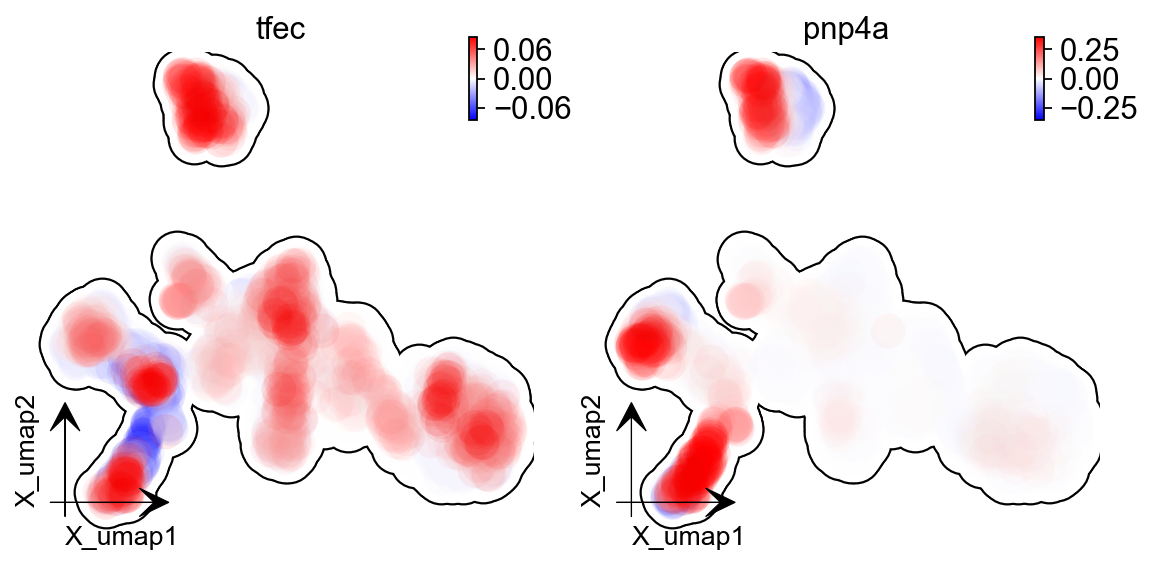

In [14]:
dyn.pl.umap(adata, color=['tfec', 'pnp4a'], 
            layer='velocity_S', frontier=True,
           figsize=(5,4),dpi=80)

This is for acceleration of genes `tfec` and `pnp4a`. 

|-----------> plotting with basis key=X_umap
|-----------> plotting with basis key=X_umap


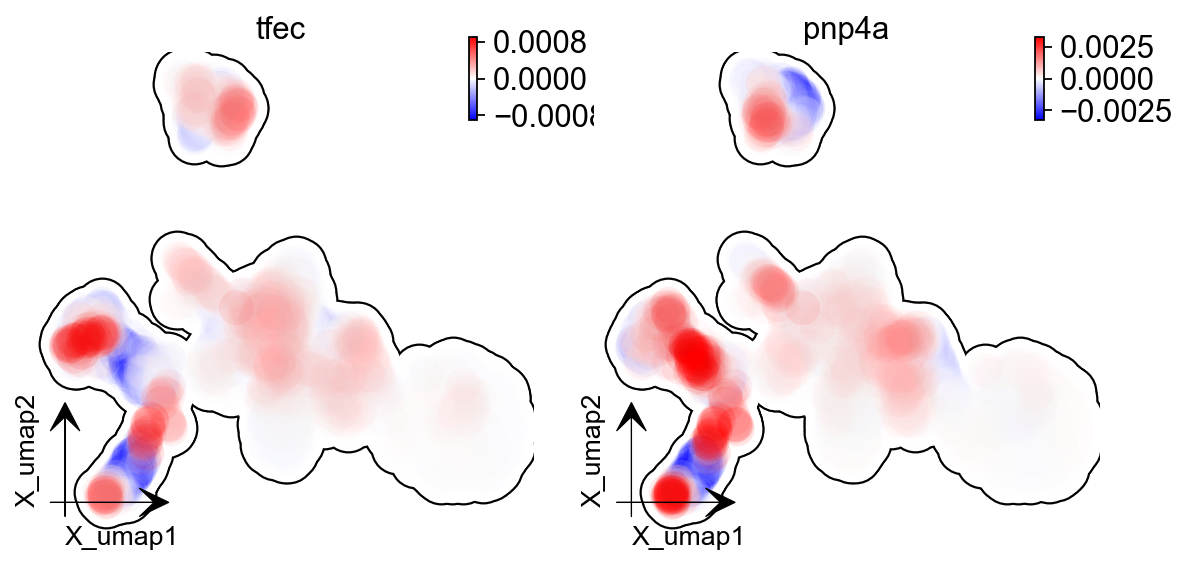

In [15]:
dyn.pl.umap(adata, color=['tfec', 'pnp4a'], 
            layer='acceleration', frontier=True,
           figsize=(5,4),dpi=80)

This is for curvature of genes `tfec` and `pnp4a`. 

|-----------> plotting with basis key=X_umap
|-----------> plotting with basis key=X_umap


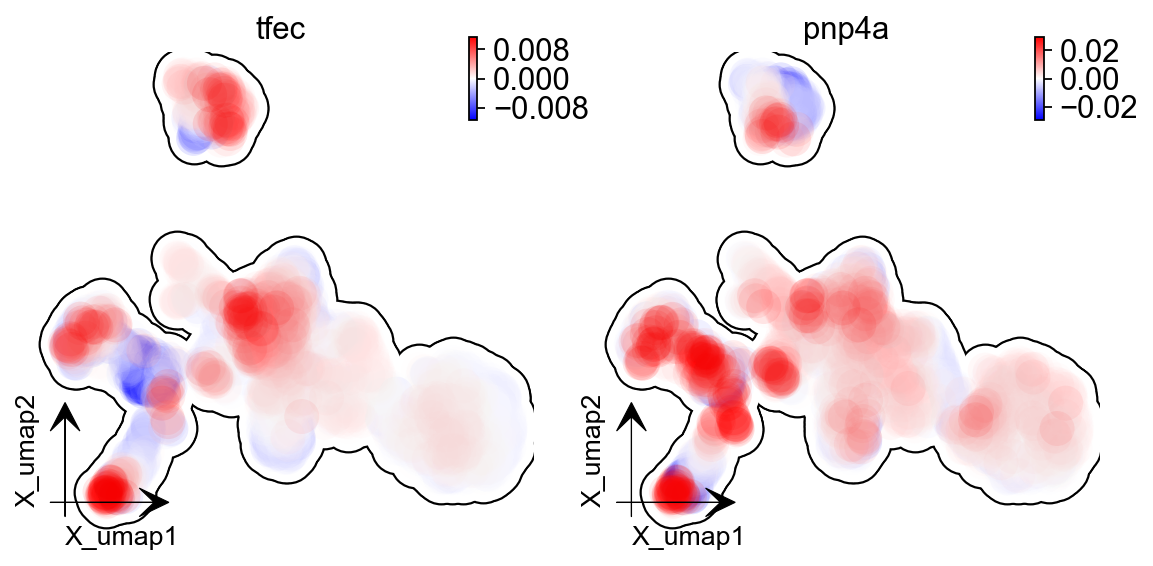

In [16]:
dyn.pl.umap(adata, color=['tfec', 'pnp4a'], 
            layer='curvature', frontier=True,
           figsize=(5,4),dpi=80)

The purpose for us to develop vaious differential geometry analyses is to derive **functional predictions**. So let us work on this a little bit next. 

#### Gene set enrichment  
In this section, we show our first approach to reveal functional insights with the {func}`dynamo.ext.enrichr` function implemented in **{mod}`dynamo`**, a python wrapper for Enrichr, to identify biological pathways with statistical significance.

We noticed that the previous study (Saunders, et al. 2019) reported a "unknown" cell type from their conventional markers based cell-typing method based on total RNA expression levels. We wonder whether we can unveil its cell-type identify with **dynamo**. Therefore, we perform gene set enrichment analysis with the top-ranked genes with the highest absolute acceleration from this previously "unknown" cell type. Interestingly, we found the genes were enriched in chondrocyte-related pathways, indicative of a potential chondrocytic origin. 

In [17]:
enr = dyn.ext.enrichr(adata.uns['rank_abs_acceleration']['Unknown'][:250].to_list(), 
                      organism='Fish', outdir='./enrichr', 
                      gene_sets='GO_Biological_Process_2018')

<Axes: title={'center': 'abs acceleration ranking'}, xlabel='Combined Score'>

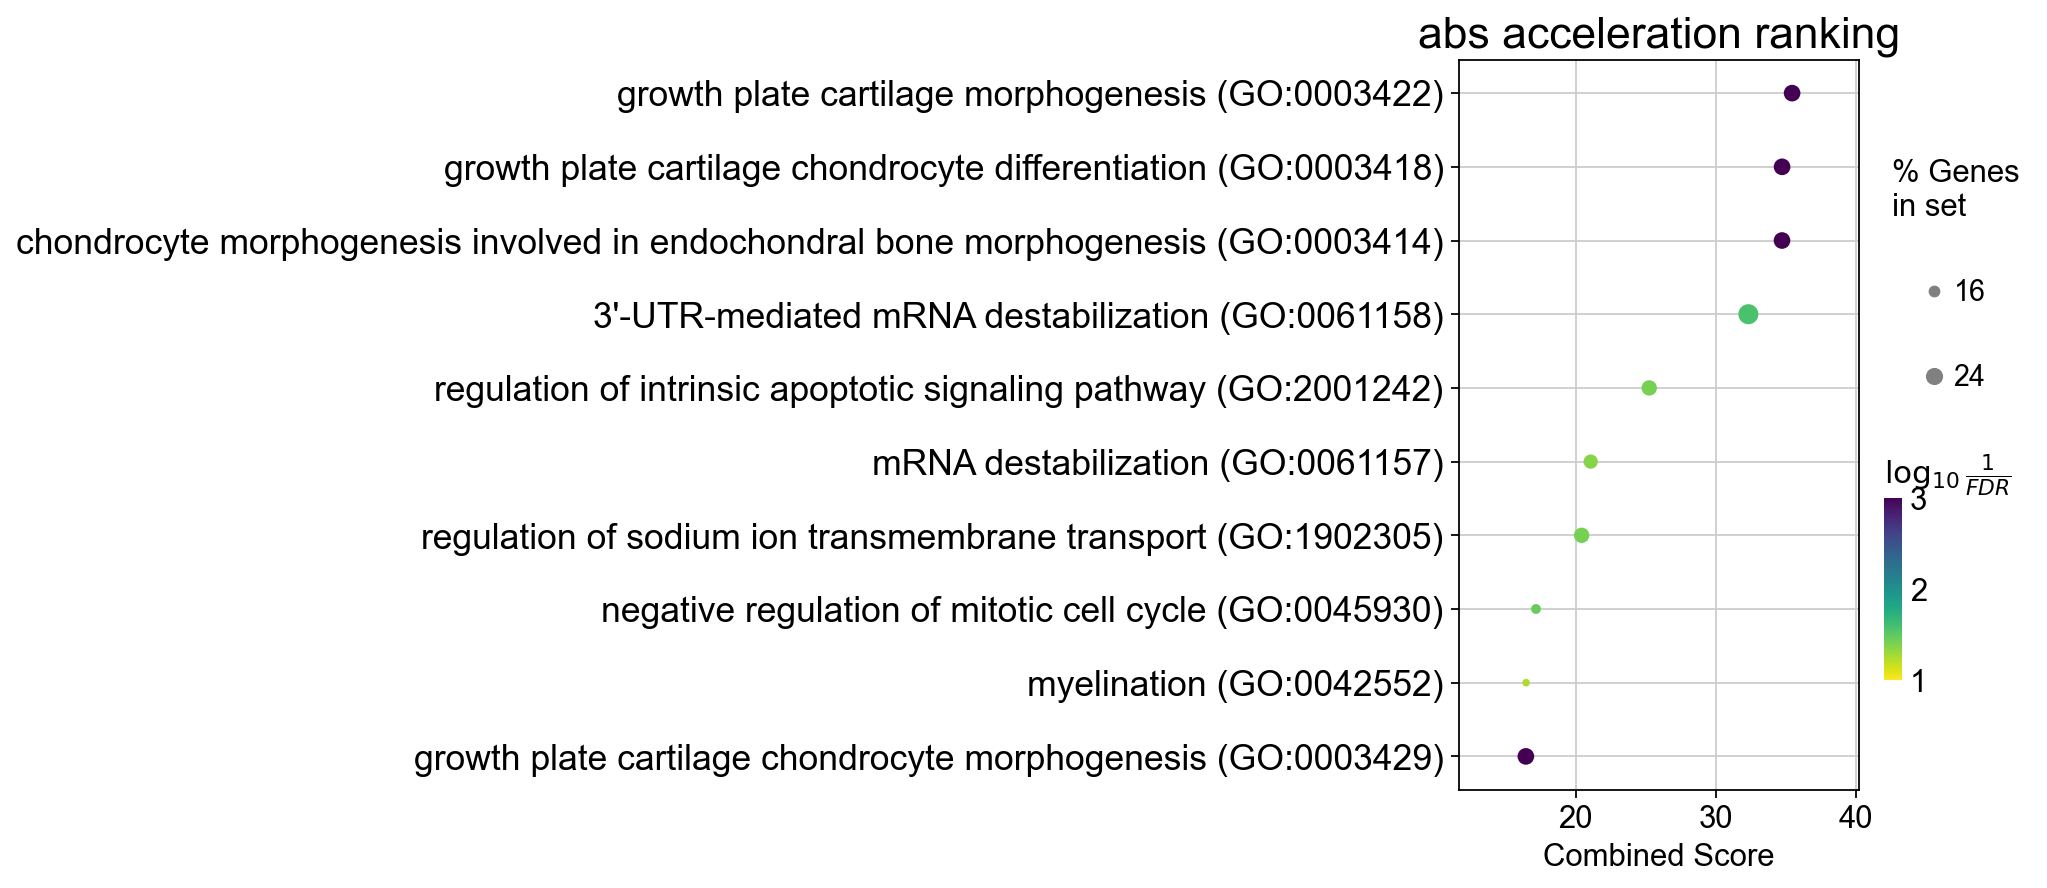

In [18]:
from gseapy.plot import barplot, dotplot
dotplot(enr.res2d, title='abs acceleration ranking', cmap='viridis_r', cutoff=0.1)

#### Jacobian Calculation and Ranking
Next we will calculate Jacobian for each cell with the reconstructed vector field. If we use PCA space, {meth}`dynamo.vf.jacobian` can project the low dimension Jacobian results back to high dimension to get a cell by gene by gene tensor. You can check the `jacobian_gene` key from the `.uns["jacobian_pca"]` dictionary in the resulted adata object to confirm this.

The cell by gene by gene tensor is generally huge, especially for datasets with large number of cells. We thus would love to do some preprocessing to alleviate the burden of computational resource requirements, either by restricting the calculation to genes that have high loading in our pca analysis or by downsampling the cells that will be used to calculate the `jacobian matrix` in each cell.  

For the first one, we will use {func}`dynamo.pp.top_pca_genes` to calculate `top_pca_genes` for adata, according to PCs loading in `adata.uns`. Note that `n_top_genes` below means we take the union of genes with top **n** absolute values for each principal components, so the resulting PCA genes may be larger than 100.

For the second one, we can use the following parameters in {func}`dynamo.vf.jacobian`. 

```python 
sampling=None,
sample_ncells=1000,
```

When the sampling is chosen from one of the `'random', 'velocity', 'trn'`, the function will sample `sample_ncells` according to the sampling method `sample` for the Jacobian matrix calculation in only `sample_ncells` sampled cells. We recommend **{mod}`dynamo`** users to start considering sampling cells with your adata object with more than 2500 cells while the top pca gene selected will be around 500.

In [19]:
dyn.pp.top_pca_genes(adata, n_top_genes=100)

AnnData object with n_obs × n_vars = 4167 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'ntr', 'cell_cycle_phase', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'acceleration_pca', 'curvature_pca'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'score', 'log_cv', 'log_m', 'frac', 'use_for_pca', 'ntr', 'use_for_dynamics', 'use_for_transition', 'top_pca_genes'
    uns: 'pp', 'velocyto_SVR', 'feature_selection', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'cell_phase_order', 'cell_phase_genes', 'vel_params_names', 'dynamics', 'neighbors', 'umap_fit', 'grid_velocity_umap', 'Cell_type_colors', 'grid_velocity_pca', 'VecFld_pca', 'rank_velocity_S', 'rank_abs_velocity_S', 'rank_acceleration', 'rank_abs_acceleration', 'rank_

Select top pca genes (flagged in `top_pca_genes` in `.var` after running `pp.top_pca_genes`) and use those genes to set the regulator/effectors that are necessary in cell-wise `jacobian matrix` calculation. 

In [20]:
top_pca_genes = adata.var.index[adata.var.top_pca_genes];

Here we will ensure a set of the chondrocyte-related gene included in the Jacobian calculation so that we can visualize the regulatory network for those genes. You can include other set of genes you care about as long as they are genes used for pca dimension reduction, that is `adata[:, genes].var.use_for_pca` are all `True`.

In [21]:
top_pca_genes = ["erbb3b", "col6a3", "vwa1", "slc35c2", "col6a2", "col6a1"] + list(top_pca_genes)

In [22]:
dyn.vf.jacobian(adata, regulators=top_pca_genes, effectors=top_pca_genes);

Transforming subset Jacobian: 100%|██████████| 4167/4167 [00:37<00:00, 110.67it/s]


We can take advantage of the cell-wise `jacobian matrix` to investigate gene regulation at single-cell resolution or a state-dependent fashion. 

In iridophore cells, we found that `pnp4a` was potentially activated by `tfec` in the progenitors of iridophore lineage which is in line with that reported in Petratou et al. 2021. Futhermore, there seem to have a possible repression occurring when tfec expression level was high in the mature iridophore cells.

We can visualize the regulation from `tfec` to `pnp4a` ($\frac{\partial f_{pnp4a}}{\partial f_{tfec}}$) on the umap embedding. $\frac{\partial f_{pnp4a}}{\partial f_{tfec}}$ denotes the effects of changing the expression of `tfec` to the velocity of `pnp4a`. 

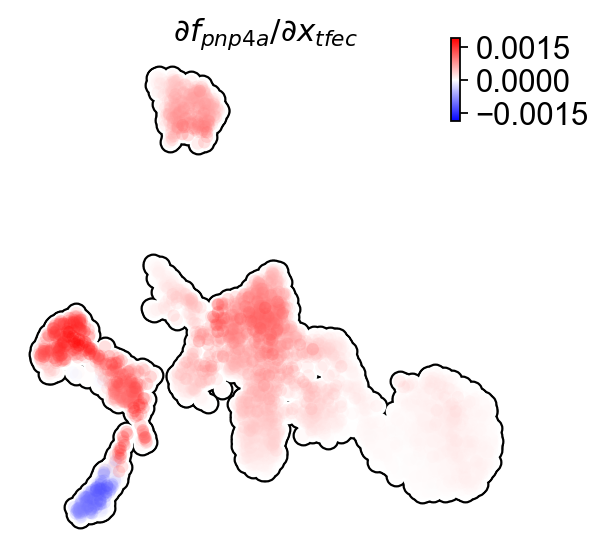

In [25]:
dyn.pl.jacobian(adata, regulators=['tfec'], 
                effectors=['pnp4a'], basis='umap',
               figsize=(4,4))

Similarly, we can also visualize the regulation from `tfec` to `pnp4a` ($\frac{\partial f_{pnp4a}}{\partial f_{tfec}}$) on top of the gene expression level of `tfec` (*x-axis*) to `pnp4a` (*y-axis*). 

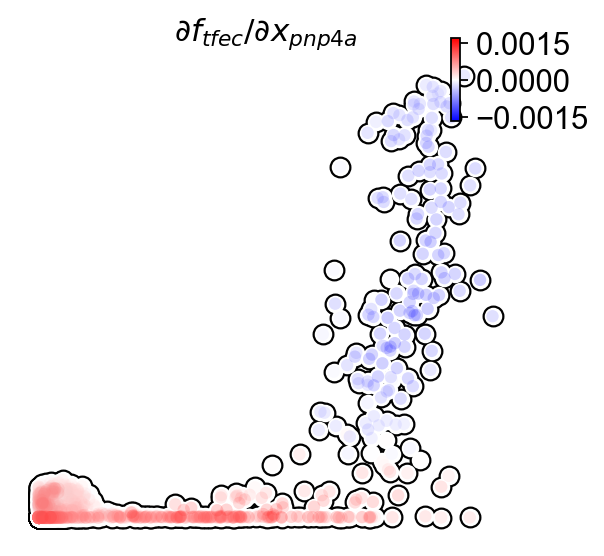

In [27]:
dyn.pl.jacobian(adata, regulators=['pnp4a'], effectors=['tfec'], 
                x='tfec', y="pnp4a", layer='M_s', basis='umap',
               figsize=(4,4))

##### Ranking for Jacobian matrices

After estimating the cell-wise Jacobian matrix, we now demonstrate different ways to rank genes based on the Jacobian matrix with **dynamo**. 

We start with the so-called "divergence" ranking for each cell group. The "divergence" we are talking about here is different from the definition of `divergence` which is basically the sum of the diagonal elements of the Jacobian. Instead the `divergence` in this context points to the self-activation or self-inhibition terms. 

The results of divergence ranking are stored in `adata.uns['rank_div_gene_jacobian_pca']`.

In [28]:
divergence_rank = dyn.vf.rank_divergence_genes(adata, groups='Cell_type');

In [30]:
divergence_rank.head()

,Chromaffin,Iridophore,Melanophore,Neuron,Other Glia,Pigment Progenitor,Proliferating Progenitor,Satellite Glia,Schwann Cell,Schwann Cell Precursor,Unknown,Xanthophore
0,mt2,tyrp1b,tspan36,mt2,tyrp1b,tyrp1b,tyrp1b,tuba8l3,plp1b,tyrp1b,ptmaa,si:ch211-251b21.1
1,mbpb,pmela,fosb,mbpb,plp1b,pmela,pmp22a,mt2,tyrp1b,pmela,mbpb,sdc4
2,mbpa,mt2,sdc4,gfap,pmela,pnp4a,ptmaa,tyrp1b,pmela,si:ch211-156j16.1,cldn19,wu:fc46h12
3,tyrp1b,gfap,fhl2a,mbpa,pmp22a,mt2,mbpa,pmp22a,MREG,pnp4a,mbpa,tspan36
4,pnp4a,mdkb,CRIP2,tyrp1b,gstp1,fhl2a,cldn19,tubb5,gstp1,mbpa,fstl3,tyrp1b


We can rank all other elements in the Jacobian. There are 5 parameters we provide in {func}`dynamo.vf.rank_jacobian_genes`'s argument list to rank the Jacobian:

* "full reg" or "full_reg": top regulators are ranked for each effector for each cell group

* "full eff" or "full_reff": top effectors are ranked for each regulator for each cell group

* "reg": top regulators in each cell group

* "eff": top effectors in each cell group

* "int": top effector-regulator pairs in each cell group

Note that the default mode is "full reg". More details can be found on API pages of online documentation. {meth}`dynamo.vf.rank_jacobian_genes`

In [31]:
full_reg_rank = dyn.vf.rank_jacobian_genes(adata, 
                                           groups='Cell_type', 
                                           mode="full_reg", 
                                           abs=True, 
                                           output_values=True,
                                           return_df=True)

In [32]:
full_eff_rank = dyn.vf.rank_jacobian_genes(adata, 
                                           groups='Cell_type', 
                                           mode='full_eff', 
                                           abs=True, 
                                           exclude_diagonal=True, 
                                           output_values=True,
                                           return_df=True)

The results of full_eff and full_reg are dictionaries, whose keys are cluster (cell type in the case above) names and values are `pd.DataFrame` with rank information as well as coefficient values stored for each gene. See below:

In [33]:
type(full_reg_rank)

dict

In [34]:
print(full_reg_rank['Unknown'].shape)
full_reg_rank["Unknown"].head(2)

(467, 934)


,tmsb4x,tmsb4x_values,rplp2l,rplp2l_values,pvalb1,pvalb1_values,gfap,gfap_values,ptmab,ptmab_values,cotl1,cotl1_values,rpl37,rpl37_values,fosab,fosab_values,nfkbiab,nfkbiab_values,si:dkey-183i3.5,si:dkey-183i3.5_values,rpl36a,rpl36a_values,tlcd1,tlcd1_values,myo1cb,myo1cb_values,si:ch73-335m24.2,si:ch73-335m24.2_values,gpm6ab,gpm6ab_values,mbpb,mbpb_values,tp53inp1,tp53inp1_values,RPL41,RPL41_values,jupa,jupa_values,mbpa,mbpa_values,fstl1b,fstl1b_values,si:ch211-251b21.1,si:ch211-251b21.1_values,sdc4,sdc4_values,tuba8l4,tuba8l4_values,sparc,sparc_values,hmgb2a,hmgb2a_values,h3f3b.1,h3f3b.1_values,rpl38,rpl38_values,timp2a,timp2a_values,flj13639,flj13639_values,rplp1,rplp1_values,ptmaa,ptmaa_values,hmga1a,hmga1a_values,KRT,KRT_values,crip1,crip1_values,rgcc,rgcc_values,rtn3,rtn3_values,cd81a,cd81a_values,lgals2a,lgals2a_values,tfec,tfec_values,cox4i2,cox4i2_values,fstl3,fstl3_values,bzw1a,bzw1a_values,atf6,atf6_values,pmp22b,pmp22b_values,gstp1,gstp1_values,gch2,gch2_values,qdpra,qdpra_values,wu:fc46h12,wu:fc46h12_values,pnp5a,pnp5a_values,oca2,oca2_values,tyrp1a,tyrp1a_values,si:dkey-21a6.5,si:dkey-21a6.5_values,pfn2,pfn2_values,tyrp1b,tyrp1b_values,slc2a15b,slc2a15b_values,tspan36,tspan36_values,pmela,pmela_values,mlpha,mlpha_values,MREG,MREG_values,elovl1b,elovl1b_values,cyp2n13,cyp2n13_values,atp6ap2,atp6ap2_values,p4hb,p4hb_values,ppp1caa,ppp1caa_values,cd63,cd63_values,mcl1b,mcl1b_values,hmgn2,hmgn2_values,pmp22a,pmp22a_values,hsf2,hsf2_values,tuba8l3,tuba8l3_values,dynll1,dynll1_values,slc22a7a,slc22a7a_values,stmn4,stmn4_values,ctsba,ctsba_values,zgc:136930,zgc:136930_values,si:dkeyp-117h8.2,si:dkeyp-117h8.2_values,aldocb,aldocb_values,cd74a,cd74a_values,zgc:153704,zgc:153704_values,uraha,uraha_values,cfl1,cfl1_values,sept15,sept15_values,sncga,sncga_values,elovl1a,elovl1a_values,adka,adka_values,pnp4a,pnp4a_values,mt2,mt2_values,crabp1a,crabp1a_values,h2afvb,h2afvb_values,ak1,ak1_values,pef1,pef1_values,slc44a2,slc44a2_values,rhoub,rhoub_values,CYST,CYST_values,slc16a1a,slc16a1a_values,serinc1,serinc1_values,lim2.2,lim2.2_values,SHROOM2,SHROOM2_values,arl6ip1,arl6ip1_values,tubb4b,tubb4b_values,midn,midn_values,egr2b,egr2b_values,tubb5,tubb5_values,si:dkey-262k9.4,si:dkey-262k9.4_values,fxyd6l,fxyd6l_values,si:ch211-202a12.4,si:ch211-202a12.4_values,fhl2a,fhl2a_values,anxa2a,anxa2a_values,rasgef1ba,rasgef1ba_values,CRIP2,CRIP2_values,tpd52l1,tpd52l1_values,zgc:110699,zgc:110699_values,alx4a,alx4a_values,si:dkey-4e7.3,si:dkey-4e7.3_values,sox10,sox10_values,atp1b1a,atp1b1a_values,pcdh7a,pcdh7a_values,lgmn,lgmn_values,nrgna,nrgna_values,vat1,vat1_values,fa2h,fa2h_values,mdka,mdka_values,hmgb1a,hmgb1a_values,anxa13l,anxa13l_values,npc2,npc2_values,rap1b,rap1b_values,map1lc3b,map1lc3b_values,mdh1aa,mdh1aa_values,cmtm7,cmtm7_values,cirbpa,cirbpa_values,tpm3,tpm3_values,efhd1,efhd1_values,cdkn1bb,cdkn1bb_values,CABZ01032488.1,CABZ01032488.1_values,glrx,glrx_values,oacyl,oacyl_values,calm2a,calm2a_values,FBXO,FBXO_values,mcl1a,mcl1a_values,col4a1,col4a1_values,sepp1a,sepp1a_values,krt18,krt18_values,itm2ba,itm2ba_values,fez1,fez1_values,hsp90b1,hsp90b1_values,ehd2b,ehd2b_values,anxa5b,anxa5b_values,calm2b,calm2b_values,btg1,btg1_values,cd9b,cd9b_values,gapdhs,gapdhs_values,phlda2,phlda2_values,ip6k2a,ip6k2a_values,fosb,fosb_values,ugt8,ugt8_values,si:ch211-260e23.9,si:ch211-260e23.9_values,CR854824.1,CR854824.1_values,pleca,pleca_values,cx27.5,cx27.5_values,rnd3b,rnd3b_values,ndrg1a,ndrg1a_values,plekha1a,plekha1a_values,fxyd1,fxyd1_values,si:dkey-73n8.3,si:dkey-73n8.3_values,sema3b,sema3b_values,ninj2,ninj2_values,si:rp71-19m20.1,si:rp71-19m20.1_values,basp1,basp1_values,pbx4,pbx4_values,eno1a,eno1a_values,ctsd,ctsd_values,si:dkey-164f24.2,si:dkey-164f24.2_values,plp1b,plp1b_values,mpz,mpz_values,hmgb3a,hmgb3a_values,cd99l2,cd99l2_values,canx,canx_values,entpd1,entpd1_values,ndfip2,ndfip2_values,myo10l3,myo10l3_values,cldn19,cldn19_values,AKAP,AKAP_values,anxa3b,anxa3b_values,tjp2b,tjp2b_values,si:ch211-222l21.1,si:ch211-222

From the above table, we can see that in the previously "Unknown" cell type, the top two regulators of tmsb4x gene (the first column in the above table) are `mbpb` and `si:ch211-156j16.1` with their aggregate regulation strength based on Jacobian `0.001429` and `0.001422`, respectively. The same applies to other columns and similarly to the `full_eff_rank` dictionary. 

In [35]:
eff_rank = dyn.vf.rank_jacobian_genes(adata, groups='Cell_type', 
                                      mode='eff', abs=True, output_values=True)

In [36]:
reg_rank = dyn.vf.rank_jacobian_genes(adata, groups='Cell_type', 
                                      mode='reg', abs=True, exclude_diagonal=True)

`int` stands for interactions, the pairs of (gene1, gene2) values in jacobian matrix.

In [37]:
int_rank = dyn.vf.rank_jacobian_genes(adata, groups='Cell_type', mode='int', 
                                      exclude_diagonal=True, output_values=True)

##### Construct and visualize cell-type specific regulatory networks

With the `full_reg_rank` and `full_eff_rank` calculated, we can now pass a set of genes of interests and use them to build a regulatory network for any specific cell type and then visualize the network with either an arcPlot or a circosPlot, etc. 

We build networks for each cell type by passing the argument `cluster = "Cell_type"` to {meth}`dynamo.vf.build_network_per_cluster` function. The edges and their weights are based on the above ranking full regulator/effector dictionaries (pass as values to the `full_reg_rank` and `full_eff_rank` arguments).

Interesting, Jacobian analysis revealed potential regulation of the chondrocyte marker `slc36c2` by the pigment regulator `erbb3`, consistent with previous reports that `EGFR (erbb3)` signaling is critical for maintaining the chondrocyte lineage (Fisher et al. 2007). In addition, this analysis revealed a strong connection between chondrocyte-specific markers `col6a3`, `col6a`, `col6a2`, and `vwa1`. 

Here we will use a few key gene in the “unknown” cell cluster to build a regulatory network based on the estimated cell-wise Jacobian matrices of chondrocyte cells. 

In [39]:
import networkx as nx
import numpy as np

unknown_cell_type_regulators = ["erbb3b", "col6a3", "vwa1", "slc35c2", "col6a2", "col6a1"]
edges_list = dyn.vf.build_network_per_cluster(adata,
                                              cluster='Cell_type',
                                              cluster_names=None,
                                              full_reg_rank=full_reg_rank,
                                              full_eff_rank=full_eff_rank,
                                              genes=np.unique(unknown_cell_type_regulators),
                                              n_top_genes=100)
network = nx.from_pandas_edgelist(edges_list['Unknown'], 'regulator', 
                                  'target', edge_attr='weight', create_using=nx.DiGraph())

|-----> [iterating reg_groups] in progress: 100.0000%|-----> [iterating reg_groups] completed [1.4136s]


Network can then be visualized as an Arcplot:

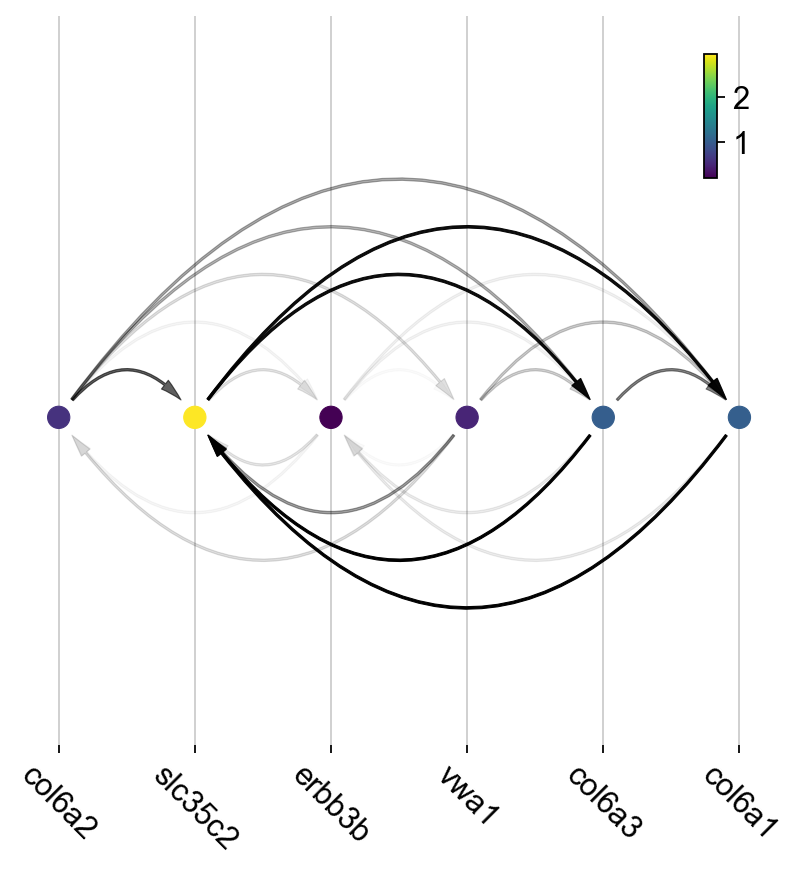

In [40]:
ax=dyn.pl.arcPlot(adata, cluster="Cell_type", cluster_name="Unknown", 
                  edges_list=None, network=network, color="M_s")

Similarly, network can also be built with other criteria and visualized with other plots, like the circos plot or hive Plot. For example, we can select 10 top genes with highest absolute acceleration values in `Unknown` cell type.

In [41]:
selected_genes = adata.uns['rank_abs_acceleration']['Unknown'][:10]

In [42]:
edges_list = dyn.vf.build_network_per_cluster(adata,
                                              cluster='Cell_type',
                                              cluster_names=None,
                                              full_reg_rank=full_reg_rank,
                                              full_eff_rank=full_eff_rank,
                                              genes=selected_genes,
                                              n_top_genes=1000)


|-----> [iterating reg_groups] in progress: 100.0000%|-----> [iterating reg_groups] completed [1.6208s]


We can then focus on analyzing `Unknown` cell type network and construct networkx graph structure for `Unknown` cell group. We next constrain the edges by removing all edges with weight <= 0.0015.

In [43]:
network = nx.from_pandas_edgelist(edges_list['Unknown'].drop_duplicates().query("weight > 0.0015"), 
                                  'regulator', 'target', 
                                  edge_attr='weight',
                                  create_using=nx.DiGraph())

Before drawing a circos plot, we can insert attributes into `networkx` `Graph` object. In the code cell below, we assign average `M_s` values to each cluster to color the nodes in the circos plot later.

In [44]:
color_key = "M_s"
cluster_key = "Cell_type"
selected_cluster = "Unknown"
adata_layer_key = "M_s"
for node in network.nodes:
    network.nodes[node]["M_s"] = adata[:, node].layers["M_s"].mean()

for edge in network.edges:
    network.edges[edge]["weight"] *= 1000

Lastly, we can visulize the network with {meth}`dynamo.pl.circosPlot`.

<Axes: >

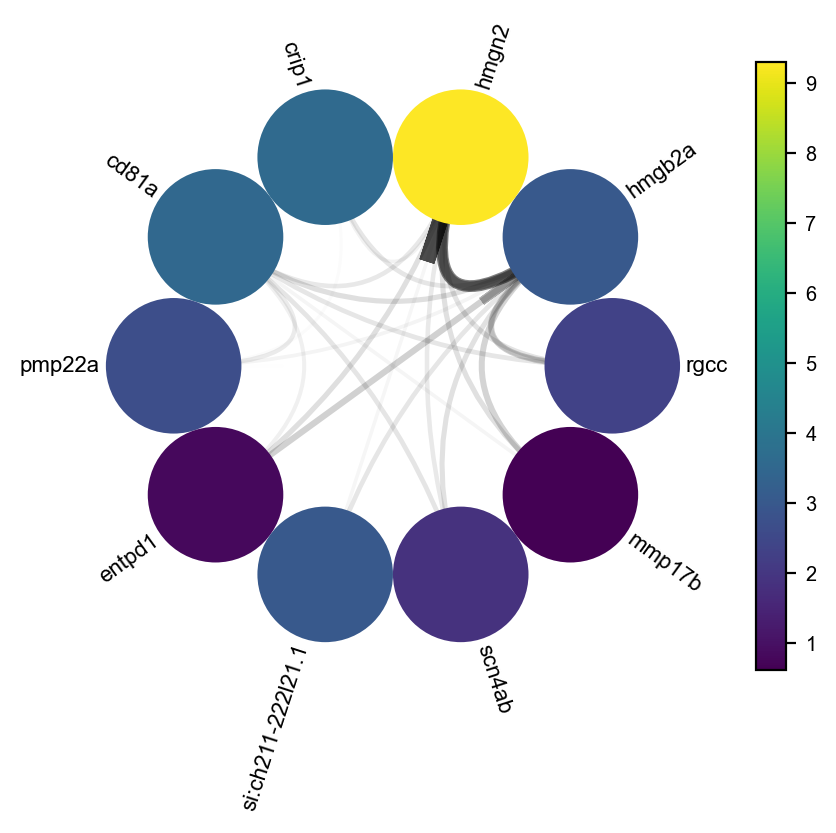

In [46]:
dyn.configuration.set_figure_params(background='white')
dyn.pl.circosPlot(network, node_color_key="M_s", 
                  show_colorbar=True, 
                  edge_alpha_scale=0.7, edge_lw_scale=0.7)

#### Visualize gene expression, velocity, acceleration, curvature as a function of vector field based pseudotime. 

Here we can apply {meth}`dynamo.ext.ddhodge` to first obtain a measure of pseudotime that is based on learned vector field function. Then we can visualize gene expression, velocity, acceleration, curvature as a function of vector field based pseudotime to reveal different aspects of gene expression kinetics over time. 

The kinetic heatmap shown below indicates that there are a few distinct stages of gene expression changes (or velocity, acceleration, curvature, etc.) during zebrafish pigmentation.

In [47]:
dyn.ext.ddhodge(adata, basis='pca')

|-----> graphizing vectorfield...
|-----------? nbrs_idx argument is ignored and recomputed because nbrs_idx is not None and return_nbrs=True
|-----------> calculating neighbor indices...
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> [ddhodge completed] completed [25.4098s]


In [48]:
transition_genes = adata.var_names[adata.var.use_for_transition]

Visualize the **gene expression dynamics** as a function of vector field based pseudotime (*x-axis*). 

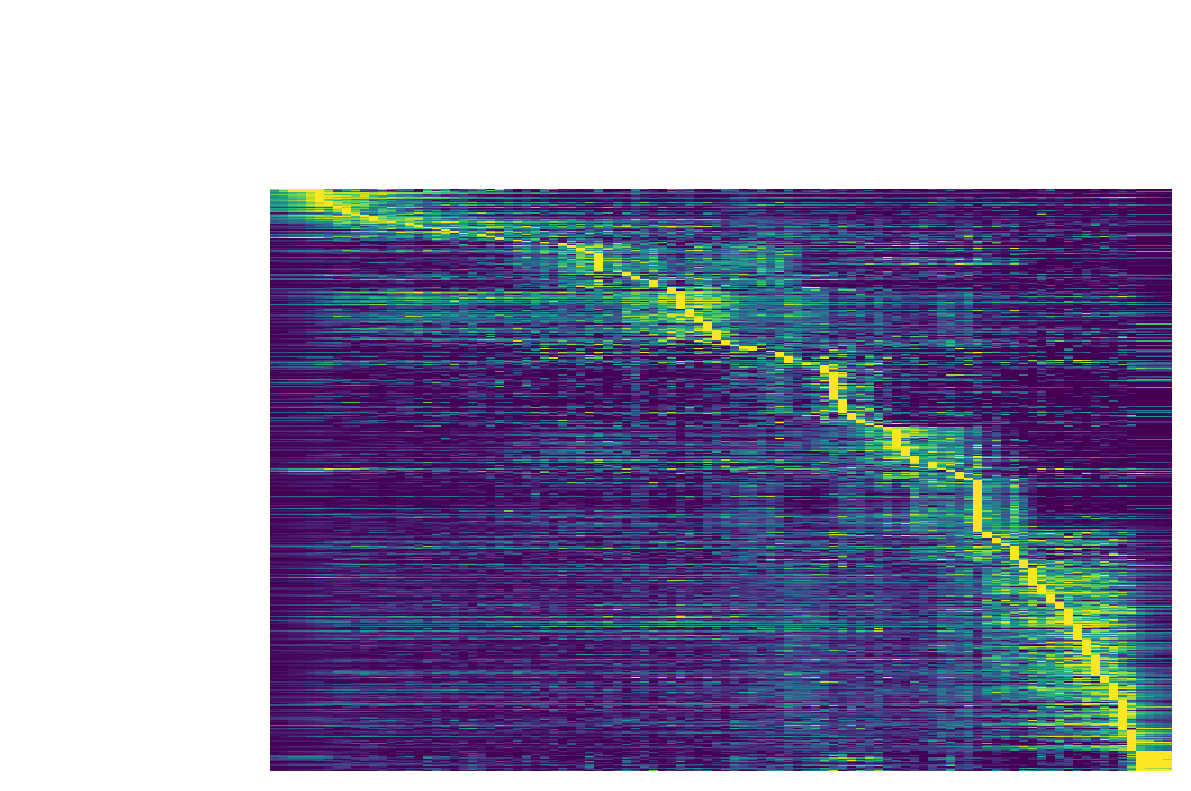

In [51]:
dyn.pl.kinetic_heatmap(adata, 
                       genes=transition_genes, 
                       tkey='pca_ddhodge_potential',
                       gene_order_method='maximum', 
                       mode='pseudotime', 
                       color_map='viridis',
                       yticklabels=False,  
                       figsize=(6,4)
                      )

Note that if you want to visualize the gene expression for a specific cell lineage, you can subset the adata via something like (the same applies to other kinetic heatmaps): 

Let us check the `melanophore` lineage by cross referencing the vector-field based pseudotime and the streamline plots, overlaied with cell-type annotations.

|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap
|-----------> plotting with basis key=X_umap
|-----------> skip filtering Cell_type by stack threshold when stacking color because it is not a numeric type


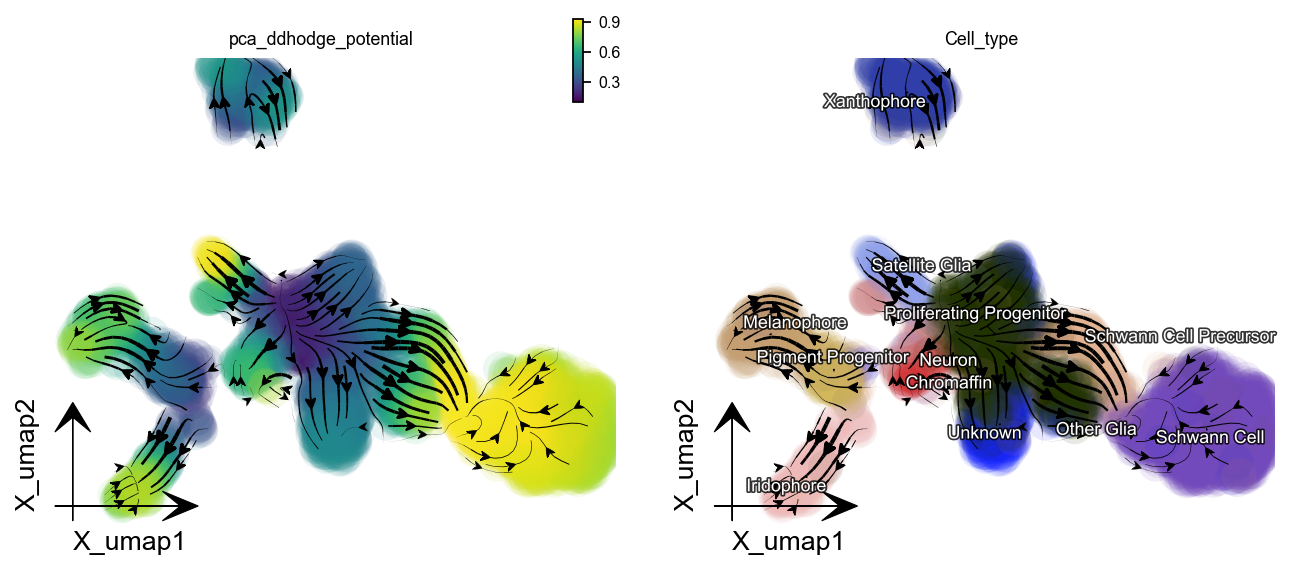

In [53]:
dyn.pl.streamline_plot(adata, color=['pca_ddhodge_potential', 'Cell_type'],
                       figsize=(5,4),s_kwargs_dict={'adjust_legend':True,'dpi':80},)

We can then collect cells from `Proliferating Progenitor`, `Pigment Progenitor`, `Melanophore` that forms the melanophore lineage by subseting adata object. This adata subset is then used to visualize the expression kinetic heatmap for the melanophore lineage. 

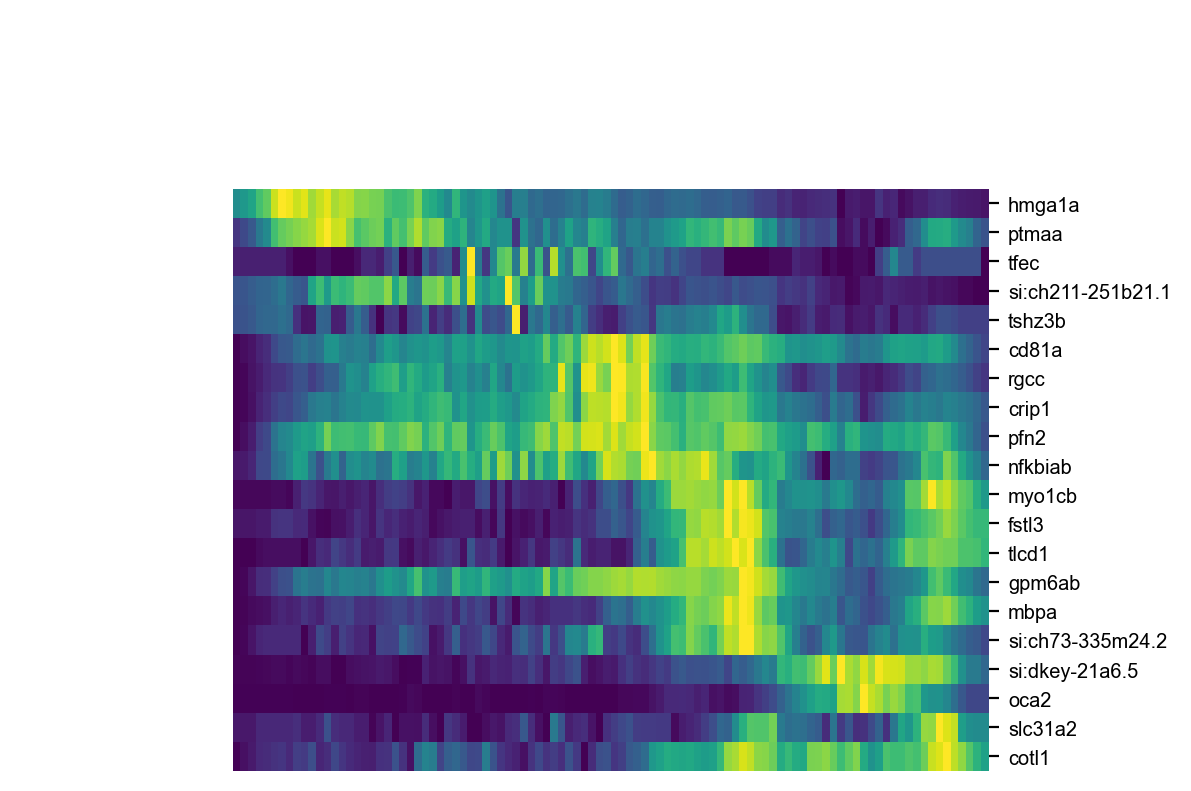

In [56]:
subset = adata[adata.obs.Cell_type.isin(['Proliferating Progenitor', 
                                         'Pigment Progenitor', 
                                         'Melanophore'])]

dyn.pl.kinetic_heatmap(subset, 
                       genes=transition_genes[:20], 
                       tkey='pca_ddhodge_potential',
                       gene_order_method='maximum', 
                       mode='pseudotime', 
                       color_map='viridis',
                       yticklabels=True,   
                       figsize=(6,4)
                      )

Visualize the **gene velocity dynamics** as a function of vector field based pseudotime (*x-axis*). 

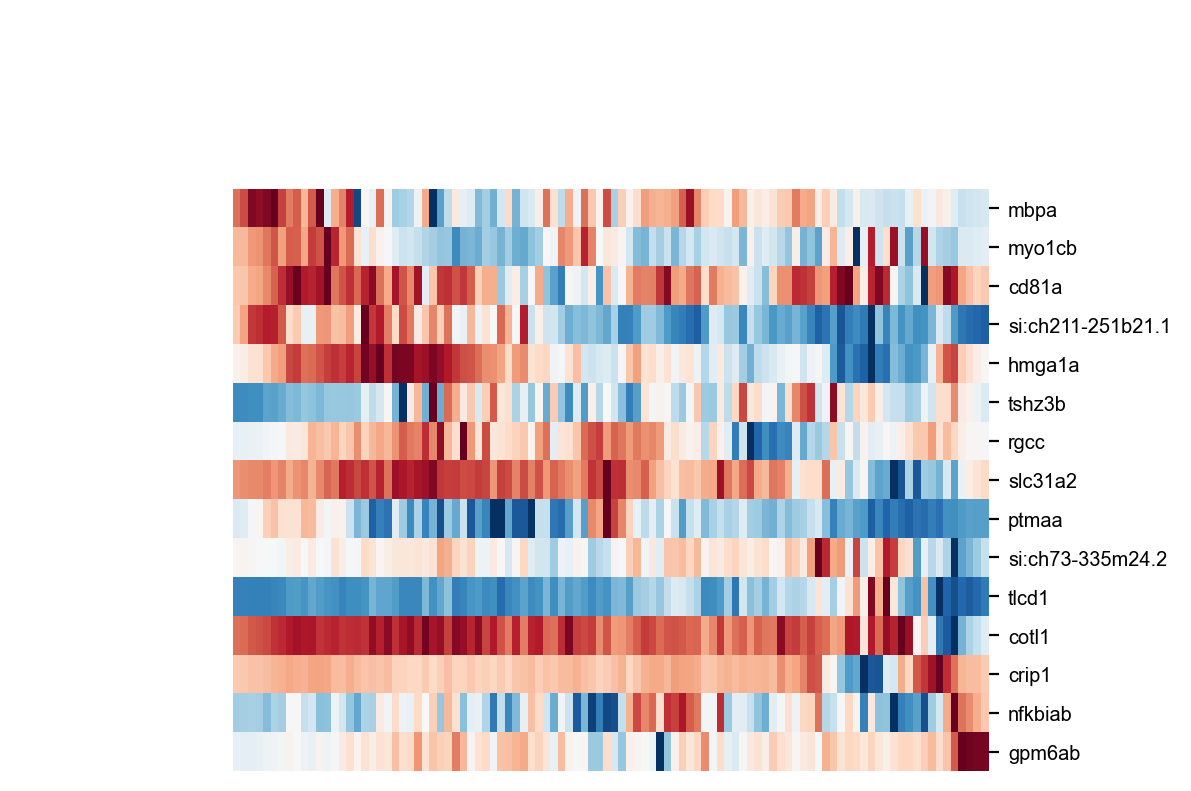

In [59]:
dyn.pl.kinetic_heatmap(adata, 
                       genes=transition_genes[:20], 
                       tkey='pca_ddhodge_potential',
                       gene_order_method='maximum', 
                       layer='velocity_S',
                       mode='pseudotime', 
                       color_map='RdBu_r',
                       yticklabels=True, 
                       figsize=(6,4)
                      )

Visualize the **gene acceleration dynamics** as a function of vector field based pseudotime (*x-axis*). 

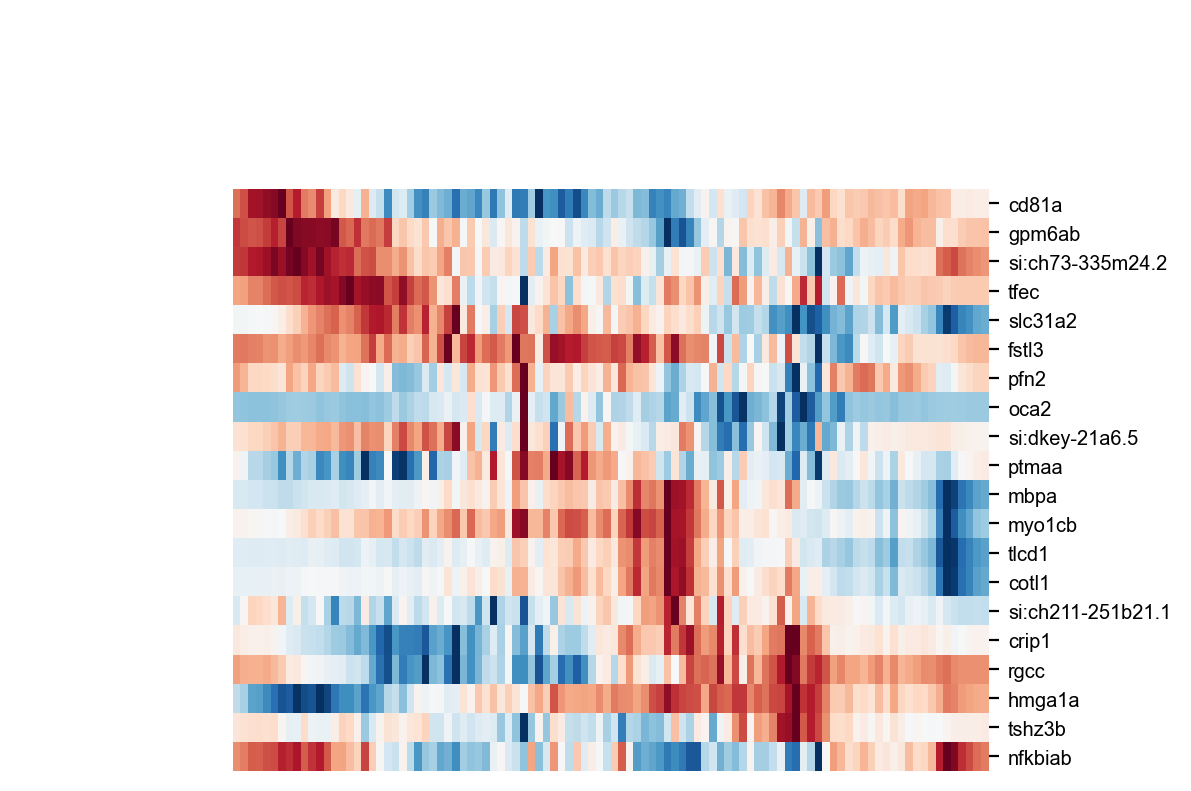

In [60]:
dyn.pl.kinetic_heatmap(adata, 
                       genes=transition_genes[:20], 
                       tkey='pca_ddhodge_potential',
                       gene_order_method='maximum', 
                       layer='acceleration',
                       mode='pseudotime', 
                       yticklabels=True,  
                       color_map='RdBu_r',
                      figsize=(6,4))

Visualize the **gene curvature dynamics** as a function of vector field based pseudotime (*x-axis*). 

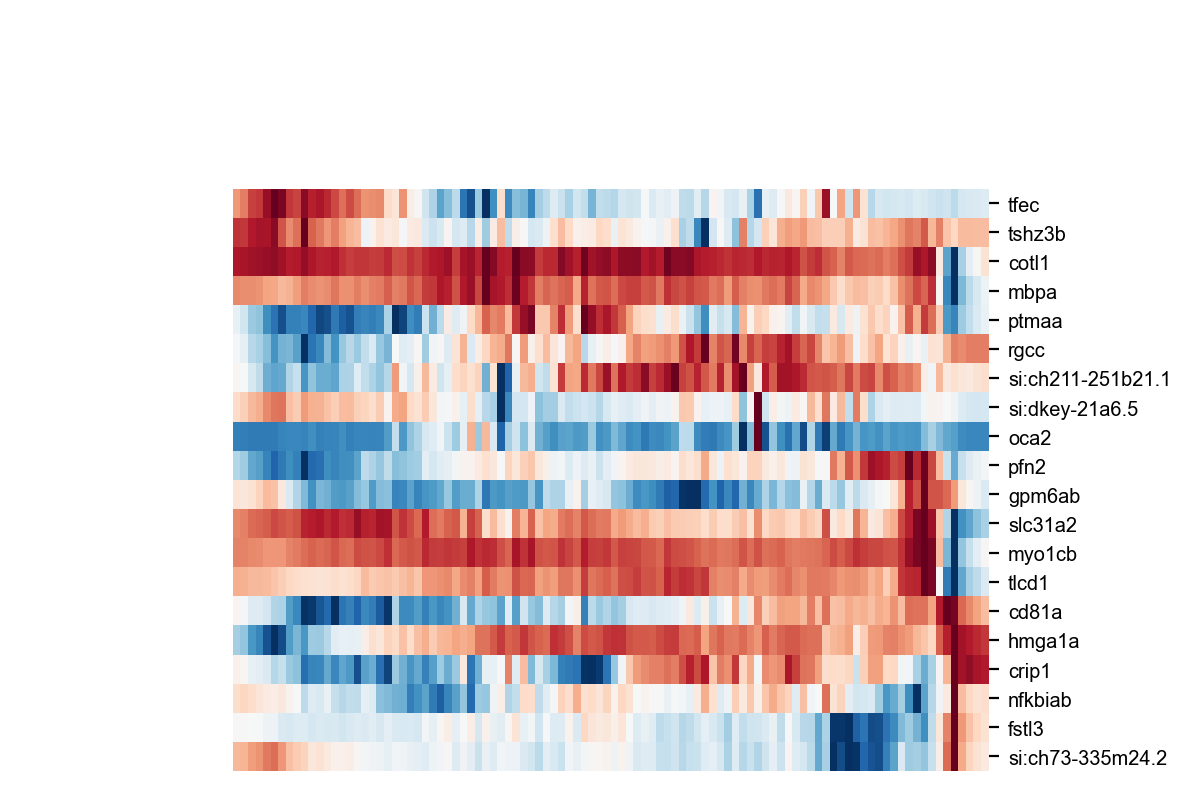

In [62]:
dyn.pl.kinetic_heatmap(adata, 
                       genes=transition_genes[:20], 
                       tkey='pca_ddhodge_potential',
                       gene_order_method='maximum', 
                       layer='curvature',
                       mode='pseudotime', 
                       yticklabels=True,  
                       color_map='RdBu_r',
                      figsize=(6,4))

#### Build transition graph between cell states

When projecting high-dimensional RNA velocity vectors into low-dimensional space, **dynamo** builds a cell-wise transition matrix by translating the velocity vector direction and the spatial relationship of each cell to its neighbors to transition probabilities, similar to velocyto, etc. **dynamo** uses a few different kernels to build such a transition matrix which can then be used to run Markov chain simulations, as we will demonstrate in future. 

On the other hand, it is of great interests to obtain a transition graph between cell types (states). **dynamo** implements such a functionality with a few methods which effectively creates a model that summarizes the possible cell type transitions based on the reconstructed Markov transition matrix between cell or the vector field function. 

To achieve this, we only need to build a state graph with {meth}`dynamo.pd.state_graph` in a specific basis for a specific grouping. For example, we can use the vector field integration based method `vf` to build a transition graph between different cell types:

In [63]:
%%capture
dyn.pd.state_graph(adata, group='Cell_type', basis='pca', method='vf')

|-----> Estimating the transition probability between cell types...
|-----> Applying vector field
|-----> [KDTree parameter preparation computation] in progress: 0.0000%|-----> [KDTree computation] completed [0.0017s]
|-----> [iterate groups] in progress: 100.0000%|-----> [iterate groups] completed [94.9211s]
|-----> [State graph estimation] completed [0.0021s]


Next, a state graph can be visualized with {func}`dynamo.pl.state_graph`.

|-----------> plotting with basis key=X_umap
|-----------> skip filtering Cell_type by stack threshold when stacking color because it is not a numeric type


<Figure size 600x400 with 0 Axes>

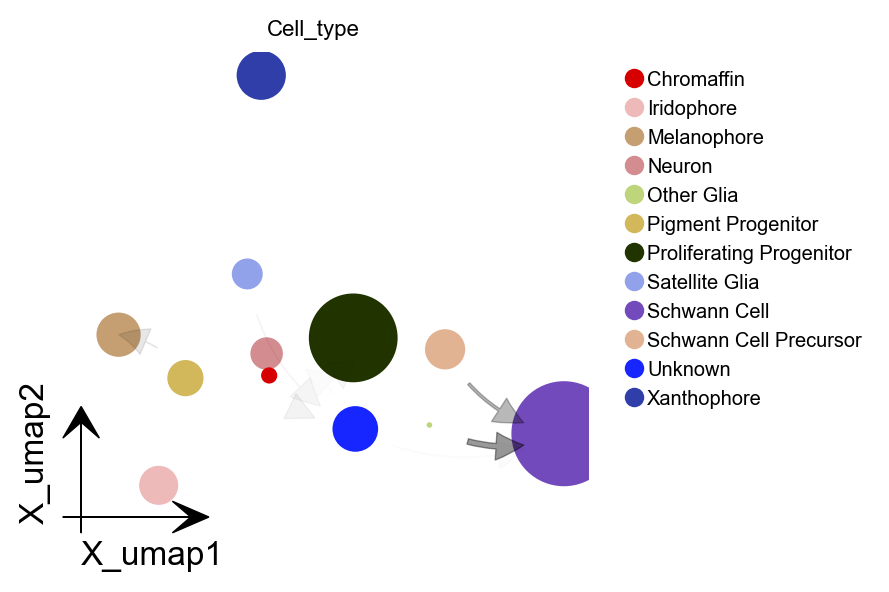

In [68]:
dyn.pl.state_graph(adata, 
                   color=['Cell_type'], 
                   group='Cell_type', 
                   basis='umap', 
                   show_legend='upper right',
                   method='vf',
                  figsize=(4.5,3))

### Save results

#### save ranking information to an excel file

**dynamo** provides an utility function to automatically save the ranking related data frames to an excel file with each ranking information saved to a separate sheet in the xlsx file. 

In [69]:
dyn.export_rank_xlsx(adata, path="result/rank_info.xlsx")

|-----> saving sheet: rank_velocity_S
|-----> saving sheet: rank_abs_velocity_S
|-----> saving sheet: rank_acceleration
|-----> saving sheet: rank_abs_acceleration
|-----> saving sheet: rank_curvature
|-----> saving sheet: rank_abs_curvature
|-----> saving sheet: rank_div_gene_jacobian_pca


#### Save data with pickle dumping or pandas dataframe to_csv

In addition, you can directly either export data to a csv file via:  

```python
adata.uns['rank_acceleration'].to_csv('./zebrafish_vf_rank_acceleration.csv')
```
Alternatively, you can save the data via pickle dump:  

```python
import pickle

pickle.dump(adata.uns['rank_acceleration'], open('./zebrafish_vf_rank_acceleration.p', 'wb'))
pickle.dump(full_reg_rank, open('./zebrafish_vf_full_reg_rank.p', 'wb'))

_acceleration_rank = pickle.load(open('./zebrafish_vf_rank_acceleration.p', 'rb'))
_acceleration_rank.head(2)
```


#### Dynamo save utility

Note that there may be intermediate results stored in adata.uns that can may lead to errors when writing the `h5ad` object. For now, we suggest users to call {func}`dynamo.cleanup`(adata) first to remove these data objects before saving the adata object.

In [124]:
dyn.cleanup(adata);

call `AnnData` `write_h5ad` to save the entire adata information.

In [125]:
adata.write_h5ad("result/tutorial_processed_zebrafish_data.h5ad")

You can load in the data later if need: 

```python
_adata = dyn.read_h5ad(("result/tutorial_processed_zebrafish_data.h5ad"))
```